<style>
    pre {
        white-space: pre-wrap;
        word-wrap: break-word;
    }
</style>

<div style="display:flex; justify-content:space-around; align-items:center; background-color:#cccccc; padding:5px; border:2px solid #333333;">
    <a href="https://estudios.upct.es/grado/5251/inicio" target="_blank">
    <img src="https://www.upct.es/contenido/universidad/galeria/identidad-2021/logos/logos-upct/marca-upct/marca-principal/horizontal/azul.png" alt="UPCT" style="height:145px; width:auto;">
    <a href="https://www.um.es/web/estudios/grados/ciencia-ingenieria-datos/" target="_blank">
    <img src="https://www.um.es/documents/1073494/42130150/LogosimboloUMU-positivo.png" alt="UMU" style="height:200px; width:auto;">
</div>

## Práctica 4: Autocodificadores
### **Sesión 3/3: Autocodificadores variacionales**


### Objetivos

- Diseño de un *autoencoder* variacional.
- Comprender el aprendizaje probabilístico y las diferencias respecto a un *autoencoder* convencional
- Comprender el concepto de reparametrización y muestreo del espacio latente.
- Aplicación a la generación de imágenes.

### Contenidos
- [El dataset CelebA](#dataset)
- [*Autoencoder* variacional](#VAE)
- [Ejercicios](#ejercicios)


<a class='anchor' id='VAE'></a>

## *Autoencoder* variacional

Un *autoencoder* variacional (VAE) es un tipo específico de *autoencoder* generativo. Mientras que un autoencoder clásico se centra en aprender una representación compacta (o codificación) para reconstruir la entrada, un autoencoder generativo, como el VAE, va un paso más allá: aprende una distribución probabilística en el espacio latente que permite generar nuevas muestras.

<div style="display:flex; justify-content:space-around; align-items:center; padding:5px solid #333333;">
    <img src="imgs/VAE.png" style="height:300px; width:auto">
</div>

Podemos resumir las principales diferencias de un VAE respecto a un *autoencoder* convencional en:

- **Aprendizaje probabilístico:**  
  En un VAE se modela la codificación como una distribución, habitualmente gaussiana de media $\mu$ y varianza $\sigma$, lo que permite tomar muestras de dicha distribución en el espacio latente $z$ y generar datos nuevos. Esto contrasta con un *autoencoder* tradicional, que produce una representación determinista.

- **Pérdida combinada:**  
  Los VAE añaden a la función de pérdida no solo el error de reconstrucción, sino también un término de divergencia KL (Kullback-Leibler) que regulariza la distribución latente $z$ para que se aproxime a la distribución de probabilidad predeterminada. Esto facilita la generación de muestras coherentes y continuas en el espacio latente.

- **Generación de nuevos datos:**  
  Mediante al muestreo en el espacio latente los VAE pueden generar nuevas datos que son similares a los datos de entrenamiento, convirtiéndolos en modelos generativos efectivos.

  A continuación se muestra un ejemplo de resultados de generación de imágenes de caras mediante VAE a partir del dataset [50k Celeba Dataset 64x64](https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64): 

<div style="display:flex; justify-content:space-around; align-items:center; padding:5px solid #333333;">
    <img src="imgs/generated_images.png" style="height:1000px; width:auto">
</div>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Layer, Activation 
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K 
from tensorflow.keras.optimizers import Adam, 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score 

In [3]:
# Importar librerías necesarias
import os
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Descargar el dataset
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/therealcyberlord/50k-celeba-dataset-64x64"

dataset_path = get_file(origin=dataset_url, extract=True)

base_dir = os.path.join(os.path.dirname(dataset_path), '50k-celeba-dataset-64x64', '50k')
try:
    os.listdir(base_dir)
except:
    base_dir = os.path.join(os.path.dirname(dataset_path), '50k')

print(f"Leyendo imágenes desde {base_dir:s}")

# Preparar listas para imágenes
NUMBER_OF_IMAGES = 10000 # <= 50000
IMAGE_DIM = (64, 64)

images = np.empty((NUMBER_OF_IMAGES, *IMAGE_DIM, 3))
images_gray = np.empty((NUMBER_OF_IMAGES, *IMAGE_DIM, 1))
for i, img_file in enumerate(os.listdir(base_dir)):
    if (i > 0) and (i%1000 == 0):
        print(f"Cargadas {i:d} imágenes...")
    if i == NUMBER_OF_IMAGES:
        break
    img_path = os.path.join(base_dir, img_file)
    img = load_img(img_path, target_size=IMAGE_DIM, color_mode='rgb')   # Redimensionar imágenes
    images[i] = img_to_array(img) / 255.0            # Normalizar a [0, 1]
    images_gray[i] = rgb_to_grayscale(images[i])

Leyendo imágenes desde C:\Users\ruben\.keras\datasets\50k
Cargadas 1000 imágenes...
Cargadas 2000 imágenes...
Cargadas 3000 imágenes...
Cargadas 4000 imágenes...
Cargadas 5000 imágenes...
Cargadas 6000 imágenes...
Cargadas 7000 imágenes...
Cargadas 8000 imágenes...
Cargadas 9000 imágenes...
Cargadas 10000 imágenes...


In [ ]:
# Dividimos en entrenamiento y prueba para evaluar
x_train, x_test = train_test_split(images_gray, test_size=0.2, random_state=42)
print(f"Datos de entrenamiento: {x_train.shape}")
print(f"Datos de prueba: {x_test.shape}")

x_train_rgb, x_test_rgb = train_test_split(images, test_size=0.2, random_state=42)
print(f"Datos de entrenamiento RGB: {x_train_rgb.shape}")
print(f"Datos de prueba RGB: {x_test_rgb.shape}")

<a class='anchor' id='ejercicios'></a>

## Ejercicios

**E1:** Partiendo del trabajo de la sesión anterior, adapte un *autoencoder* convolucional de 3 niveles de profundidad, utilizando capas convolucionales 2D de 16, 32 y 64 mapas de características, más el nivel correspondiente al espacio latente (dimensión 64), para que se comporte como un *autoencoder* variacional. Para ello se debe atender a los aspectos puntualizados en el [apartado previo](#VAE) y [personalizar el modelo](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing) para: 1) incorporar la reparametrización y muestreo del espacio latente, forzando su estadística a una distribución normal (se requieren capas adicionales totalmente conectadas para enlazar con el nuevo espacio latente reparametrizado), y 2) implementación de la pérdida combinada (suma de la pérdida estándar del *autoencoder* con la pérdida de divergencia KL).

### **CONSTRUCCIÓN DE LA ARQUITECTURA MEDIANTE PERSONALIZACIÓN:**
- **Capa de Muestreo** 

Primero, creamos una capa personalizada que implementará el truco de reparametrización: z = $\mu_z$ + exp(0.5 * $\sigma_z^2$) * $\epsilon$.

In [14]:
class Sampling(Layer):
    """Usa (z_mean, z_log_var) para muestrear z, el vector que codifica la entrada."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) # Usar K.random_normal
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

- **Modelo VAE** 

Ahora, definimos la clase VAE. Esta clase contendrá:

1) El encoder modificado que será entrenado para producir los vectores de medias y log_varianzas(diagonal matriz de covarianzas).

2) La capa de muestreo previamente definida **Sampling**.

3) El decoder como red generativa que obtiene las características del espacio latente (provenientes de la distribución de probabilidad inducida) para generar/reconstruir a partir de este (tiene una arquitectura similar)

4) La lógica para calcular la pérdida combinada:

**`Loss` = Pérdida_Reconstrucción(MAE) + $\beta$ Pérdida de reconstrucción Divergencia KL**

Comentar que solo especificamos la pérdida que se produce por la regularización de la divergencia KL, la pérdida por reconstrucción será introducida en la compilación del modelo, en esa compilación será añadida la regularización para inducir al modelo a que tenga una distribución de probabilidad específica gracias al método **add_loss()**.

In [38]:
def build_vae_functional(input_shape, latent_dim=64, kl_weight=1.0):
    # ENCODER
    encoder_input = Input(shape=input_shape, name='encoder_input')
    
    # Capas Convolucionales
    x = Conv2D(16, (3, 3), strides=2, padding='same', name="enc_conv1")(encoder_input)
    x = Activation('relu', name="enc_relu1")(x)
    # No BatchNormalization después de la primera capa Conv
    
    x = Conv2D(32, (3, 3), strides=2, padding='same', name="enc_conv2")(x)
    x = BatchNormalization(name="enc_bn2")(x)
    x = Activation('relu', name="enc_relu2")(x)
    
    x = Conv2D(64, (3, 3), strides=2, padding='same', name="enc_conv3")(x)
    x = BatchNormalization(name="enc_bn3")(x)
    x = Activation('relu', name="enc_relu3")(x)
    
 
    # Calcular dimensiones antes de aplanar (shape_before_flattening)
    # Teniendo 3 capas convolucionales con strides=2 cada una tendríamos entonces una dimensión previa al aplanado de (8, 8, 64)
    shape_before_flattening = K.int_shape(x)[1:] 

    # Aplicamos la capa Flatten para aplanar los mapas de características generados tras pasar por las capas de convolución
    # obteniendo así un vector 1D que se interconecta con las capas densas que modelizan los vectores de media y varianza que definen la distribución latente para esa entrada
    
    x = Flatten(name="enc_flatten")(x)
    
    # Capas densas para z_mean y z_log_var
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    
    # Capa de muestreo: es donde introducimos el truco de la reparametrización para permitir propagar el error hacia el encoder
        # si no hacemos esto, el muestreo sería totalmente estocástico y no podríamos calcular el gradiente para actualizar los pesos del encoder
    z = Sampling(name='z_sampling')([z_mean, z_log_var])
    
    # Modelo Encoder creado
    encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')



    # DECODER 
    decoder_input = Input(shape=(latent_dim,), name='decoder_input_standalone')

    # Después de la capa de muestreo, el vector z se pasa a través de una capa densa para expandirlo a la forma original de los mapas de características mediante la capa Reshape
    # La capa Reshape toma el vector denso y lo convierte en un tensor 3D con la forma (8, 8, 64) para que coincida con la salida de la última capa convolucional del encoder
    target_shape_dense = np.prod(shape_before_flattening)
    x_dec = Dense(target_shape_dense, activation='relu', name="dec_dense")(decoder_input)
    x_dec = Reshape(shape_before_flattening, name="dec_reshape")(x_dec)
    
    # Capas deconvolucionales (transpuestas) para reconstruir la imagen
    x_dec = Conv2DTranspose(32, (3, 3), strides=2, padding='same', name="dec_conv_t1")(x_dec)
    x_dec = BatchNormalization(name="dec_bn_t1")(x_dec)
    x_dec = Activation('relu', name="dec_relu_t1")(x_dec)
    
    x_dec = Conv2DTranspose(16, (3, 3), strides=2, padding='same', name="dec_conv_t2")(x_dec)
    x_dec = BatchNormalization(name="dec_bn_t2")(x_dec)
    x_dec = Activation('relu', name="dec_relu_t2")(x_dec)
    
    num_output_channels = input_shape[-1] # Podemos manejar escala de grises o RGB según el número de canales del input
    decoder_output = Conv2DTranspose(num_output_channels, (3, 3), strides=2, padding='same', name='decoder_output')(x_dec)
    
    # Modelo Decoder creado
    decoder = Model(decoder_input, decoder_output, name='decoder')


    # --- VAE (Conexión Encoder-Decoder) ---
    # Tomamos la salida 'z' del encoder y la pasamos al decoder
    vae_output = decoder(encoder(encoder_input)[2]) # encoder(inputs)[2] es 'z'
    
    vae = Model(encoder_input, vae_output, name=f'vae_latent_{latent_dim}')
    

    



    # --- CÁLCULO Y ADICIÓN DE LA PÉRDIDA KL ---
    # La pérdida KL se calcula usando z_mean y z_log_var (salidas del encoder)
    # kl_loss por muestra: suma sobre las dimensiones latentes
    kl_loss_per_sample = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss para el lote: media sobre las muestras del lote
    kl_loss_batch_mean = K.mean(kl_loss_per_sample)
    
    # Añadir la pérdida KL al modelo. Se multiplicará por kl_weight durante el entrenamiento.
    vae.add_loss(kl_weight * kl_loss_batch_mean)
    
    # Añadir métricas para poder ver la pérdida KL durante el entrenamiento 
    vae.add_metric(kl_loss_batch_mean, name='kl_loss_metric', aggregation='mean')
    
    return vae, encoder, decoder


In [ ]:
INPUT_SHAPE = (64, 64, 3) 
LATENT_DIM = 64
KL_WEIGHT = 0.001 

In [ ]:
vae_color, encoder_color, decoder_color = build_vae_functional(
    input_shape=INPUT_SHAPE, 
    latent_dim=LATENT_DIM,
    kl_weight=KL_WEIGHT
)
vae_color.summary() 


Model: "vae_latent_64"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 64),         548384      ['encoder_input[0][0]']          
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 decoder (Functional)           (None, 64, 64, 3)    289955      ['encoder[0][2]']                
                                                                                      

**E2:** Entrene el modelo con las imágenes de caras en color, y genere conjuntos de nuevas imágenes, similares a los mostrados en el [apartado previo](#VAE). Comente las diferencias en cuando a prestaciones con un *autoencoder* convolucional: calidad de la reconstrucción conseguida, número de parámetros necesarios en el modelo, tiempo de entrenamiento, etc. Tenga en cuenta que dado que el objetivo fundamental en este caso es generar imágenes y no reconstruirlas, los conjuntos de validación y test son prescindibles, y la parada anticipada puede realizarse directamente sobre el conjunto de entrenamiento (el sobreajuste puede mejorar la capacidad de generación de imágenes).

In [41]:
print(f"Forma Imágenes de entrenamiento: {images.shape}")

Forma Imágenes de entrenamiento: (10000, 64, 64, 3)


Usaremos `MAE` como pérdida de reconstrucción. No usaremos validation_data ni `EarlyStopping` agresivo, ya que el **sobreajuste** puede ser beneficioso para la generación.

In [51]:
# Definimos la pérdidad de reconstrucción
reconstruction_loss_mae = tf.keras.losses.MeanAbsoluteError()

# Compilación del modelo VAE
vae_color.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss=reconstruction_loss_mae)

# Entrenamiento del VAE
# Dado que el objetivo es la generación y el sobreajuste puede ser útil,
# no usaremos un conjunto de validación explícito ni parada anticipada estricta.

EPOCHS_VAE = 300 
BATCH_SIZE_VAE = 64 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Monitorear la pérdida de entrenamiento
    patience=20,     # Paciencia para detener el entrenamiento
    min_delta=0.0001,  # Tolerancia para considerar una mejora
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)

# Entrenamiento:
history_vae_color = vae_color.fit(
    images,  # Entradas
    images,  # Objetivos (para la reconstrucción)
    epochs=EPOCHS_VAE,
    batch_size=BATCH_SIZE_VAE,
    shuffle=True,
    callbacks=[early_stopping]  
    
)

print("Entrenamiento del VAE completado.")


Epoch 1/300
157/157 [==============================] - 3s 14ms/step - loss: 0.4437 - kl_loss_metric: 17.1810
Epoch 2/300
157/157 [==============================] - 2s 14ms/step - loss: 0.2813 - kl_loss_metric: 12.7587
Epoch 3/300
157/157 [==============================] - 2s 14ms/step - loss: 0.2211 - kl_loss_metric: 16.0955
Epoch 4/300
157/157 [==============================] - 2s 14ms/step - loss: 0.1931 - kl_loss_metric: 17.2754
Epoch 5/300
157/157 [==============================] - 2s 14ms/step - loss: 0.1769 - kl_loss_metric: 18.0959
Epoch 6/300
157/157 [==============================] - 2s 14ms/step - loss: 0.1652 - kl_loss_metric: 18.4153
Epoch 7/300
157/157 [==============================] - 2s 14ms/step - loss: 0.1563 - kl_loss_metric: 18.6215
Epoch 8/300
157/157 [==============================] - 2s 14ms/step - loss: 0.1501 - kl_loss_metric: 18.5604
Epoch 9/300
157/157 [==============================] - 2s 14ms/step - loss: 0.1457 - kl_loss_metric: 18.4821
Epoch 10/300
157/15

In [ ]:
def generate_and_plot_new_faces(decoder_model, latent_dim, n_to_generate, figsize=(15, 3)):
    
    # Muestrear puntos aleatorios del espacio latente (distribución Normal estándar)
    random_latent_vectors = np.random.normal(size=(n_to_generate, latent_dim))
    
    # Generar imágenes usando el decoder
    generated_images = decoder_model.predict(random_latent_vectors)
    
    # Graficar las imágenes generadas
    plt.figure(figsize=figsize)
    for i in range(n_to_generate):
        ax = plt.subplot(1, n_to_generate, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.suptitle(f"{n_to_generate} Caras Generadas por el VAE", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()



def plot_reconstructions_vae(vae_model, original_images, n_to_show, figsize=(12,5)):
    indices = np.random.choice(len(original_images), n_to_show, replace=False)
    selected_originals = original_images[indices]
    reconstructed_images = vae_model.predict(selected_originals)

    plt.figure(figsize=figsize)
    for i in range(n_to_show):
        # Original
        ax = plt.subplot(2, n_to_show, i + 1)
        plt.imshow(selected_originals[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstruida
        ax = plt.subplot(2, n_to_show, i + 1 + n_to_show)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstruida VAE")
        plt.axis("off")
    plt.suptitle("Originales vs. Reconstrucciones VAE", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### **Tener en cuenta que los parámetros claves del modelo, que son la dimensión del espacio latente y el peso de ponderación de la regulazión KL, tienen los siguientes valores:**

- `LATENT_DIM` = 64
- `K1_WEIGHT` = 0.001


Generando nuevas imágenes de caras con el VAE entrenado...
1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0021854108..1.0086612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03257651..1.2747189].


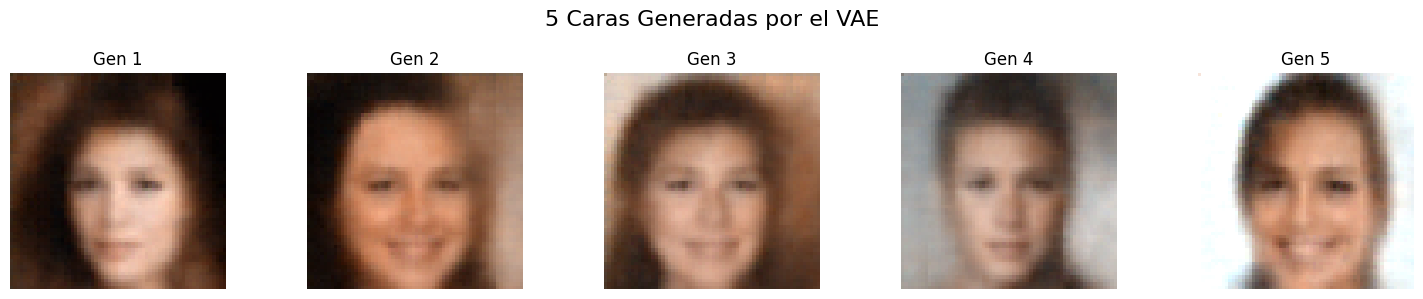


Mostrando algunas reconstrucciones del VAE...
1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.017741011..1.0210156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003917135..1.107002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011664388..0.9305111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0034600096..0.9670187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006801173..0.992551].


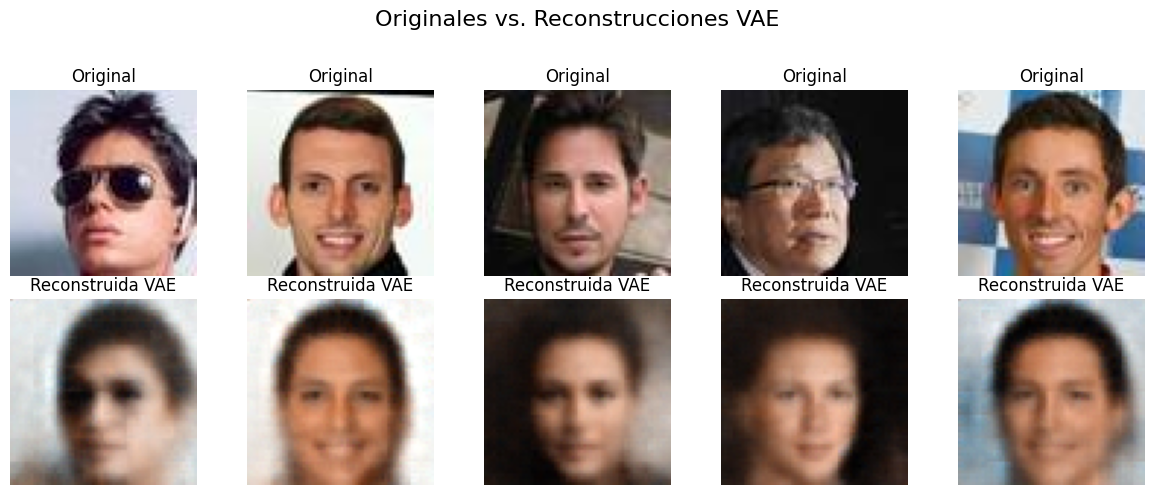

In [56]:
print("\nGenerando nuevas imágenes de caras con el VAE entrenado...")
generate_and_plot_new_faces(decoder_color, LATENT_DIM, n_to_generate=5)

print("\nMostrando algunas reconstrucciones del VAE...")
plot_reconstructions_vae(images, vae_color, n_to_show=5)

## Comparación: Autoencoder Variacional (VAE) vs Autoencoder Convolucional (CAE) 

Es importante tener en cuenta que una comparación directa en rendimiento no es del todo justa. Los CAEs se optimizan  para la **reconstrucción eficiente desde un espacio latente de baja dimensión**, mientras que los VAEs se diseñan para **aprender un espacio latente estructurado que permita la generación de nuevas muestras**. Sus métricas de éxito y compromisos de diseño difieren debido a estos objetivos distintos.

### 1. Calidad de la Reconstrucción

*   **CAE:** Producen reconstrucciones **más nítidas y fieles**. Su único enfoque es minimizar el error de reconstrucción.
*   **VAE:** Suelen generar reconstrucciones **ligeramente más borrosas o suavizadas**. Esto se debe al compromiso entre reconstruir la entrada y regularizar el espacio latente mediante la divergencia de KL para permitir la generación.

### 2. Número de Parámetros del Modelo

*   **VAE:** Generalmente, un **ligero incremento en el encoder** debido a la necesidad de dos "cabezas" (para `z_mean` y `z_log_var`) en lugar de una sola para el vector latente del CAE. El decoder puede ser idéntico.
El aumento o disminución del número de parámetros de la red depende en gran medida de esas capas densas que definen el cuello de botella de ambas arquitecturas.

### 3. Tiempo de Entrenamiento

*   **VAE:** Se puede observar que es **más lento por época** debido al cálculo adicional de la pérdida KL y el paso de muestreo. También influye el hecho de que dejamos que se sobreajuste, eso implica un mayor tiempo de entrenamiento.

### 4. Capacidad de Generación de Nuevas Muestras

*   **CAE:** **No pueden generar nuevas muestras coherentes.** Su espacio latente carece de la estructura necesaria.
*   **VAE:** Es su **fortaleza principal**. La regularización KL estructura el espacio latente, permitiendo muestrear y generar nuevas imágenes verosímiles que se asemejan a los datos de entrenamiento.


**E3:** Evalúe la influencia sobre las prestaciones analizadas en el ejercicio E2 de:
- El aumento de la dimensión del espacio latente (máximo 1024).
- La ponderación de las pérdidas en la implementación de la suma de la pérdida combinada (desde 1 a 1, hasta un máximo de 10 a 1, orientativamente).



In [ ]:
# Función de Compilación y Entrenamiento 
def compile_and_train_vae(input_shape, latent_dim, kl_weight,
                          training_data, epochs, batch_size, patience=10):
    print(f"\n--- Entrenando VAE: Latent Dim={latent_dim}, KL Weight={kl_weight} ---")

    vae_model, _, decoder_model = build_vae_functional( 
        input_shape=input_shape,
        latent_dim=latent_dim,
        kl_weight=kl_weight
    )

    reconstruction_loss_fn_mae = tf.keras.losses.MeanAbsoluteError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    vae_model.compile(optimizer=optimizer, loss=reconstruction_loss_fn_mae)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=patience,
        verbose=1,
        restore_best_weights=True
    )

    history = vae_model.fit(
        training_data,
        training_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping_cb],
        shuffle=True,
        verbose=1
    )
    print(f"Entrenamiento completado para VAE (ld={latent_dim}, klw={kl_weight})")
    return vae_model, decoder_model, history 


In [ ]:
# Parámetros
latent_dims_to_try = [64, 1024]
kl_weights_to_try = [0.1, 1.0, 5.0, 10.0]

EPOCHS_E3 = 100 
BATCH_SIZE_E3 = 32
PATIENCE_E3 = 10

modelos_VAE_E3 = {}

for ld in latent_dims_to_try:
    for klw in kl_weights_to_try:
        model_key = f"ld{ld}_klw{klw:.2f}".replace('.', '_')


        vae, decoder, hist = compile_and_train_vae(
            input_shape=images.shape[1:], # (64, 64, 3)
            latent_dim=ld,
            kl_weight=klw,
            training_data=images,
            epochs=EPOCHS_E3,
            batch_size=BATCH_SIZE_E3,
            patience=PATIENCE_E3
        )
        modelos_VAE_E3[model_key] = {
            'vae_model': vae,
            'decoder_model': decoder, # Almacena el decoder
            'history': hist,
            'latent_dim': ld,
            'kl_weight': klw
        }

print("\n\n Resumen de Métricas de los Modelos Entrenados:")
for model_name, data in modelos_VAE_E3.items():
    model = data['vae_model'] # El VAE completo para métricas de entrenamiento
    ld = data['latent_dim']
    klw = data['kl_weight']

    evaluation_results = model.evaluate(images, images, verbose=0)
    final_total_loss = evaluation_results[0]
    final_kl_loss_metric = evaluation_results[1] if len(evaluation_results) > 1 else float('nan')
    num_params = model.count_params()

    print(f"Modelo: {model_name} (Latent Dim: {ld}, KL Weight: {klw:.2f})")
    print(f"  Número de Parámetros (VAE completo): {num_params:,}")
    print(f"  Mejor Pérdida Total (VAE): {final_total_loss:.4f}")
    print(f"  Métrica KL Loss (VAE): {final_kl_loss_metric:.4f}")
    print("-" * 30)



--- Entrenando VAE: Latent Dim=64, KL Weight=0.1 ---
Epoch 1/100
313/313 [==============================] - 6s 13ms/step - loss: 0.5770 - kl_loss_metric: 3.0541
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 0.2508 - kl_loss_metric: 0.3595
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 0.2313 - kl_loss_metric: 0.1884
Epoch 4/100
313/313 [==============================] - 4s 13ms/step - loss: 0.2244 - kl_loss_metric: 0.1264
Epoch 5/100
313/313 [==============================] - 4s 14ms/step - loss: 0.2209 - kl_loss_metric: 0.0961
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 0.2184 - kl_loss_metric: 0.0762
Epoch 7/100
313/313 [==============================] - 4s 14ms/step - loss: 0.2174 - kl_loss_metric: 0.0666
Epoch 8/100
313/313 [==============================] - 4s 14ms/step - loss: 0.2161 - kl_loss_metric: 0.0564
Epoch 9/100
313/313 [==============================] - 5s 15ms/step - loss: 0.2149

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
def generate_and_plot_model_samples(decoder_model, latent_dim, kl_weight_val, n_to_generate=5, figsize_per_image=(3, 3)):
    random_latent_vectors = np.random.normal(size=(n_to_generate, latent_dim))
    generated_images = decoder_model.predict(random_latent_vectors, verbose=0)

    total_width = figsize_per_image[0] * n_to_generate
    total_height = figsize_per_image[1]
    plt.figure(figsize=(total_width, total_height + 0.5))

    for i in range(n_to_generate):
        ax = plt.subplot(1, n_to_generate, i + 1)
        img_to_show = generated_images[i]
        if img_to_show.shape[-1] == 1:
             img_to_show = np.squeeze(img_to_show, axis=-1)
             plt.imshow(img_to_show, cmap='gray')
        else:
             plt.imshow(img_to_show)
        plt.title(f"Img {i+1}")
        plt.axis("off")
    
    plt.suptitle(f"{n_to_generate} Muestras Generadas\nLatent Dim: {latent_dim}, KL Weight: {kl_weight_val:.2f}", fontsize=14, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



for model_key, data in modelos_VAE_E3.items():
    print(f"Procesando modelo para visualización: {model_key}")
    decoder = data['decoder_model']
    ld = data['latent_dim']
    klw = data['kl_weight']

    generate_and_plot_model_samples(
        decoder_model=decoder,
        latent_dim=ld,
        kl_weight_val=klw,
        n_to_generate=5
    )




**E4:** Volviendo a la configuración del ejercicio E2. codifique todas las imágenes de entrenamiento en el espacio latente, y aplique a las codificaciones resultantes una reducción de dimensionalidad a 2 dimensiones con el [algoritmo PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), y compruebe mediante representación visual de dichas componentes si la estadística de dicho espacio se ajusta la predeterminada.



313/313 [==============================] - 1s 4ms/step


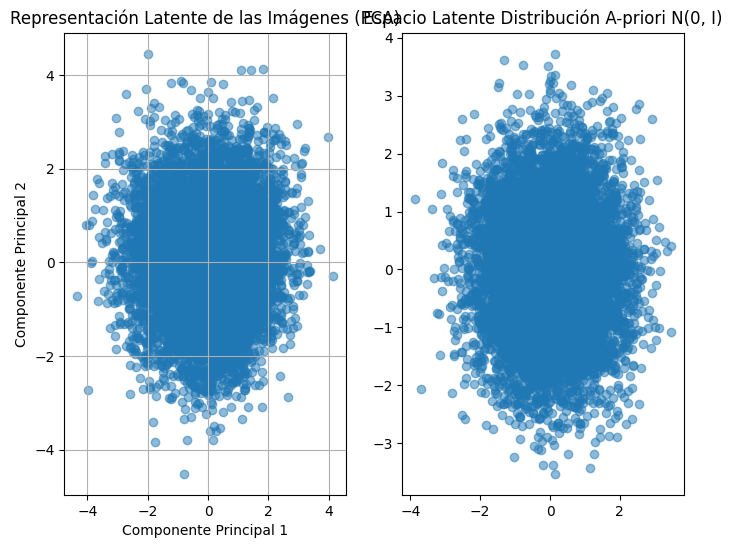

In [ ]:
from sklearn.decomposition import PCA

latent_dim = 64
encoded_images = encoder_color.predict(images)[2]  # Obtener la representación latente (z) de las imágenes originales a partir de Q(z|x)

pca = PCA(n_components=2)  # Reducir a 2 dimensiones
encoded_images_pca = pca.fit_transform(encoded_images)
random_latent_vectors = np.random.normal(size=(len(images), latent_dim))

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.scatter(encoded_images_pca[:,0], encoded_images_pca[:,1], alpha=0.5)
plt.title("Representación Latente de las Imágenes Q(z|x) (PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.axis("equal")

plt.subplot(1,2,2)
plt.scatter(random_latent_vectors[:,0], random_latent_vectors[:,1], alpha=0.5)
plt.title("Espacio Latente Distribución A-priori N(0, I) (PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.axis("equal")

plt.tight_layout()
plt.show()


plt.show()

**E5:** Dadas las particularidades del conjunto de datos (imágenes de caras), resulta directo aplicar un aumento de datos trivial que duplique el tamaño del conjunto de entrenamiento, y que consiste en realizar un giro especular (horizontal) a cada una de las imágenes, y añadir dichas imágenes al conjunto inicial de entrenamiento. Implemente dicho aumento de datos y comente su influencia en la calidad de las imágenes generadas. En función de las posibilidades de cómputo, aumente también la cantidad de imágenes del conjunto de entrenamiento que se leen inicialmente del dataset [50k Celeba Dataset 64x64](https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64)